## Домашняя работа #5.

**Kaggle: [competition](https://www.kaggle.com/competitions/hse-2023-hw-5), [invite link](https://www.kaggle.com/t/6d51db6f2dde497a9c12ecf28899082f)**

**Kaggle deadline: 06/10/2023 12:59 PM UTC**

**Hard deadline: 11.06.2023 03:00:00 +0003 GMT**

### Описание

Вам предоставлен измененный датасет CIFAR10. В нём содержится 50+10 тысяч RGB изображений размера 32х32 следующих 10 классов: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

Задача: используя свёрточные нейронные сети, добиться максимальной точности классификации.

### Данные

В данном ноутбуке уже есть код для PyTorch, отвечающий за загрузку данных. Если будете использовать этот фреймворк, можно пропустить секцию. Если же хочется использовать другой фреймворк глубокого обучения, ниже дано краткое описание формата хранения данных.

Каждый из файлов — сериализованный с помощью pickle c 4ой версией протолока python-словарик.

Список файлов:

- `meta` — метаданные датасета (например, названия классов)
- `data_train` — данные обучения, 50к примеров, по 5к на один класс
- `data_test` — данные теста, 10к примеров, по 1к на один класс, без ground-truth классов

Словарики с данными имеют следующие поля:

- `section` — имя части данных (обучение/тест)
- `names` — хеш-идентификаторы объекта
- `labels` — ground-truth классы, список из N чисел от 0 до 9
- `images` — numpy массив размером `(N, 3*32*32)` с изображениями

### Оценка

Качество решения будет оцениваться по метрике "точность". Точность – это количество правильно классифицированных картинок к общему числу картинок в тестовом наборе. Публичный лидерборд рассчитывается по 30% тестовых данных, поэтому старайтесь не переобучаться под него.

```
accuracy = (correct classified) / (total # of examples)
```

В качестве решения вы должны прислать файл формата:

```
Id,Category
0, 3
1, 2
2, 9
3, 1
...
```

где:

- `Id` — порядковый номер объекта в тестовом датасете
- `Category` — предсказанный класс объекта

В данном ноутбуке уже есть код, подготавливающий файл решения.

Итоговая оценка складывается из двух:
- по 5 баллов за преодоление каждого из бенчмарков (от 0 до 15 баллов)
- от 0 до 15 баллов за сам код решения

### Эксперименты

Так как в обучении нейросетевой модели есть очень много различных гиперпараметров, в данном домашнем задании нужно будет делать много различных экспериментов. И будет очень полезно, и для вас самих, и для нас, проверяющих, наличие текстового описания всех, или по крайней мере самых интересных / важных в выборе итоговой модели, экспериментов с результатами в финальном ноутбуке. Наличие и подробность описания экспериментов будут входить в итоговую оценку за домашнее задание. Дедлайн на Kaggle специально поставлен немного раньше, чтобы у вас было время спокойно дописать отчет об экспериментах.

## Решение

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
sources_path = Path("/content/drive/MyDrive/hw5_data")

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [ ]:
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image
import copy

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets.vision import VisionDataset
import torch.nn.functional as F

Данные лежат в секции [Data](https://www.kaggle.com/c/csc-cv21-hw5/data) kaggle-соревнования. <br>
Нужно скачать архив с данными и расспаковать его. <br>
В переменной ниже надо указать путь до датасета. <br>

In [ ]:
dataset_root = sources_path

Код для загрузки измененного датасета CIFAR10. Аргументы инициализации:

- `root` — строка, путь до директории с файлами датасета
- `train` — флаг, загружать часть для обучения или теста
- `transform` — преобразования изображения
- `target_transform` — преобразования класса изображения

In [ ]:
class CIFAR10(VisionDataset):

    def __init__(self,
                 root: str,
                 train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train

        meta_path = os.path.join(self.root, 'meta')
        with open(meta_path, "rb") as f:
            content = pickle.load(f)
            self.classes = content['label_names']
            self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        data_path = os.path.join(self.root, 'data_train' if train else 'data_test')
        with open(data_path, "rb") as f:
            content = pickle.load(f)
            self.data = content['images'].reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))
            self.targets = content.get('labels')

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index])
        target = self.targets[index] if self.targets else len(self.classes)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

### Загрузка датасета

Загружаем часть датасета для обучения.

In [ ]:
size = 224

In [ ]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

In [ ]:
data = CIFAR10(
    root=dataset_root,
    train=True,
    transform=train_transform
    )

Разбиваем случайным образом датасет на обучение и валидацию. <br>
На первой части будем обучать модель классификации. <br>
На второй части будем оценивать качество во время экспериментов. <br>

In [ ]:
train_data, val_data = torch.utils.data.random_split(
    data,
    [40000, 10000],
    generator=torch.Generator().manual_seed(42),
)

Инициализируем data loader-ы.

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

Посмотрим, какой размерности батчи выдает data loader.

In [ ]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 224, 224])
Shape of y:  torch.Size([64]) torch.int64


### Модель классификации

Определяем, на каком устройстве будем обучать модель.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


### Обучение

Задаем функцию потерь (цель оптимизации) и оптимизатор.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Код для визуализации процесса обучения.

Каждые `interval` шагов оптимизации и в конце эпох мы записываем значения функции потерь и метрик в лог. <br>
Затем вызовом функции `show_progress` обновляем график обучения. <br>

In [ ]:
# Training logs
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [ ]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show()

In [ ]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [ ]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()

    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)

    show_progress(epoch+1)

    return model, correct

Цикл обучения.

### Эксперимент 1

Предварительно сделаем resize картинки: 32 -> 128

Для сравнения моделей будем делать по 20 эпох с одним и тем же оптимизатором (сначала посмотрим какой оптимизатор лучше)

#### 1.1

Самая простая моделька с несколькими сверточными слоями и пулингом\
Оптимизатор: SGD, lr = 0.001

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 5, stride=1, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 5, stride=1, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 32 * 32, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10))

In [ ]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

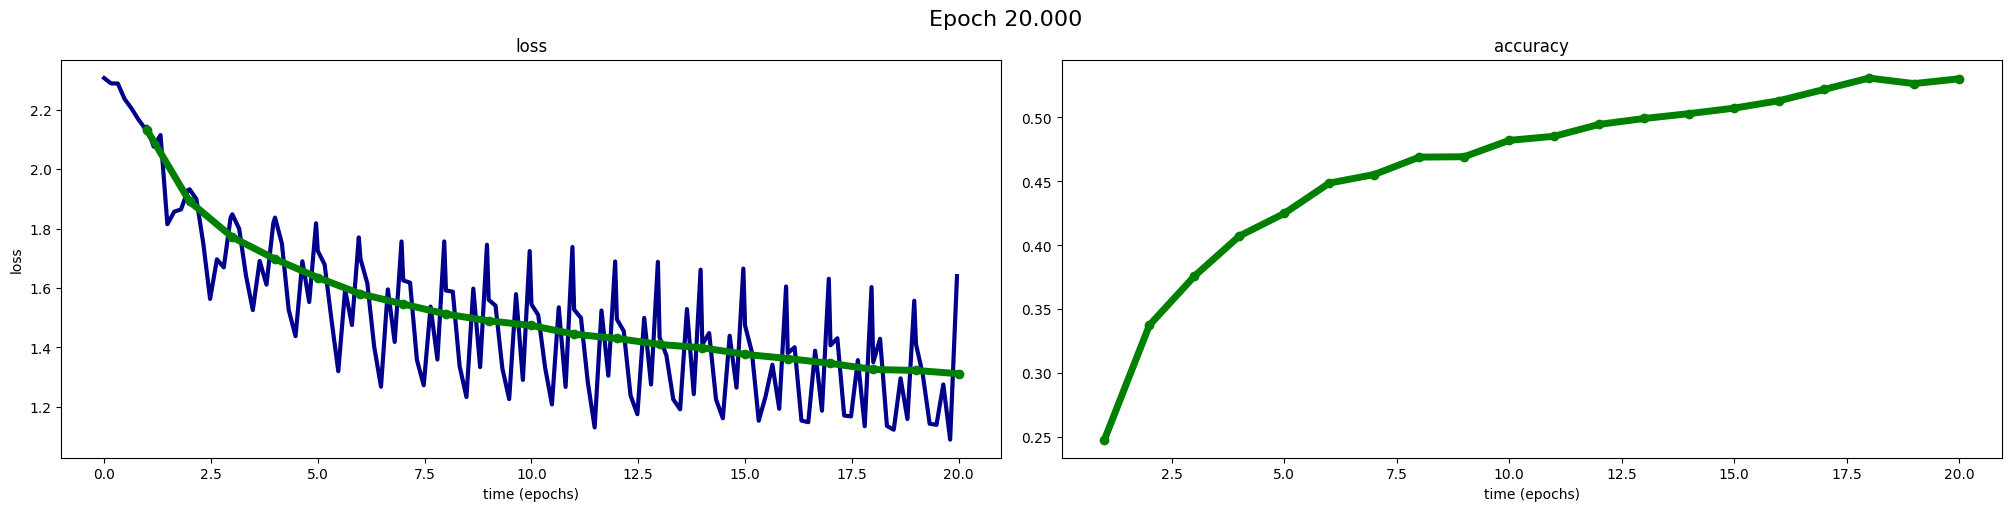

100%|██████████| 20/20 [19:57<00:00, 59.89s/it]


In [ ]:
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 20
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())

In [ ]:
best_acc

0.5308

#### 1.2

Далее затестим другой оптимизатор - Adam с параметрами по умолчанию

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 5, stride=1, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 5, stride=1, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 32 * 32, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10))

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

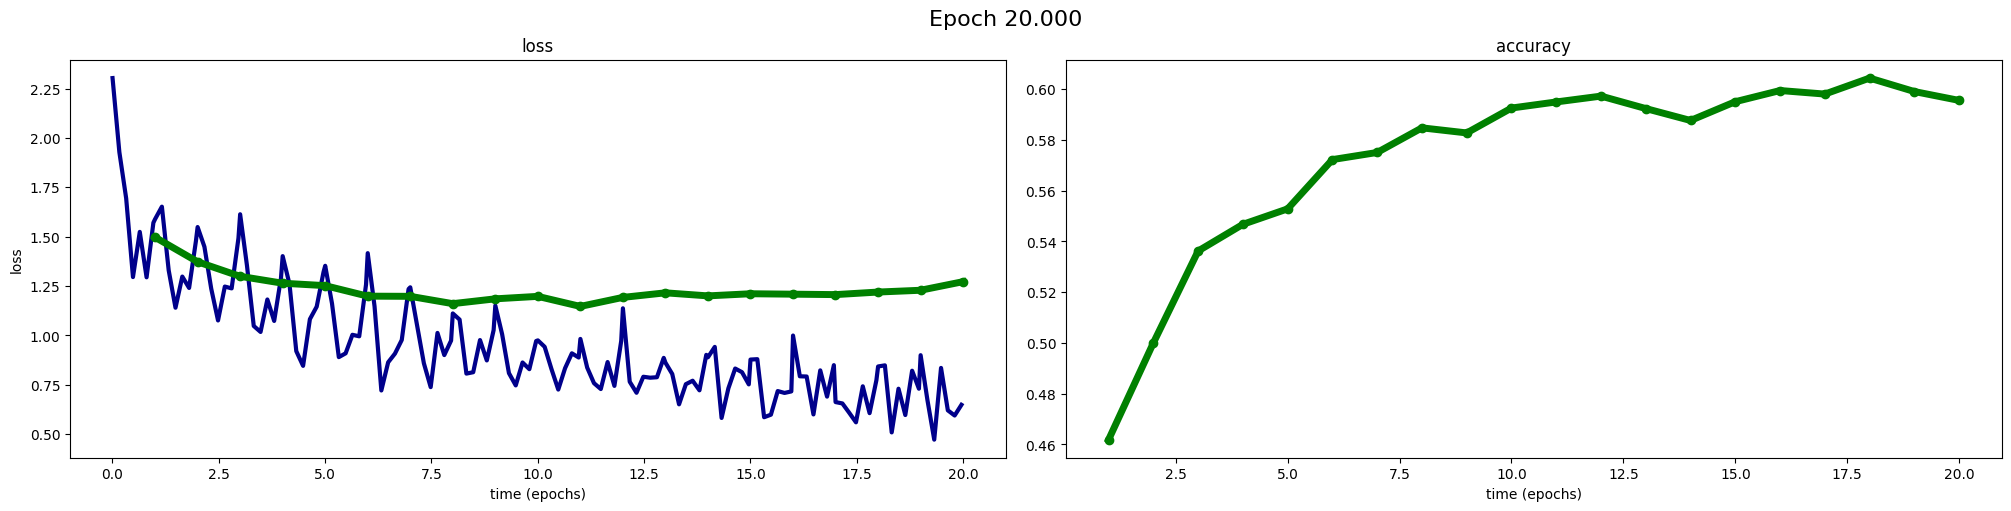

100%|██████████| 20/20 [19:32<00:00, 58.62s/it]

0.6043


In [ ]:
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 20
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())

In [ ]:
print(best_acc)

0.6043


**Вывод: для нашей задачи будем использовать Adam optimizer**\
Видно, что обучение более спокойное, не такое скачкообразное

#### 1.3

Добавим dropout

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 5, stride=1, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Conv2d(32, 64, 5, stride=1, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Flatten(),
    nn.Linear(64 * 32 * 32, 256),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(256, 10))

In [ ]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

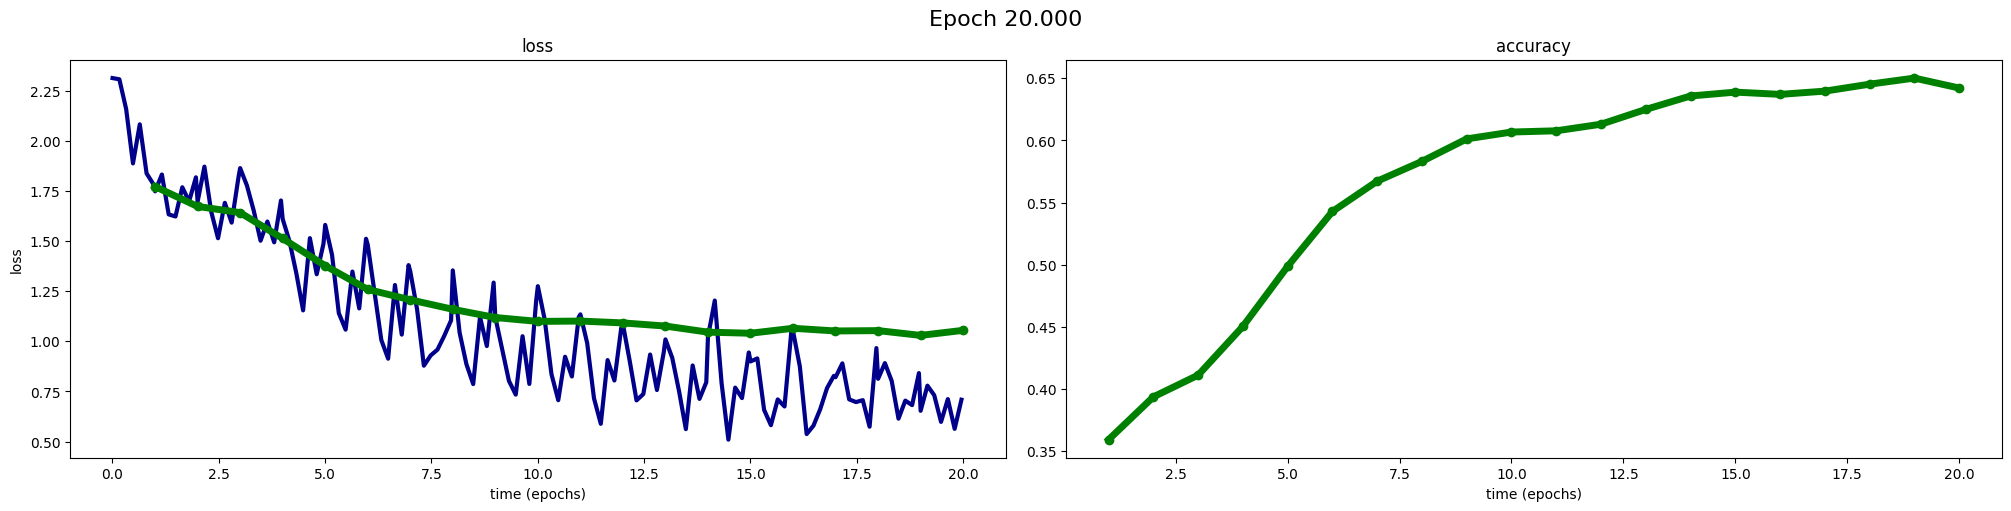

100%|██████████| 20/20 [19:37<00:00, 58.88s/it]


In [ ]:
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 20
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())

In [ ]:
print(best_acc)

0.6501


С dropout лучше! Видно, что на валидации лосс почти не уменьшается, можно сделать scheduler для lr, чтобы на последних эпохах получалось более точное решение, но, кажется, что на данной модели зацикливаться не стоит.

### Эксперимент 2

#### 2.1

Сделаем модель посложнее: добавим больше сверток, dropout и батч-нормализацию (сравним лучше с ней или без).

In [ ]:
class CNN(nn.Module):
  def __init__(self, out_1=32, out_2=64, out_3=128, fc1_out=128, fc2_out=128, batch_norm=False):
    super(CNN, self).__init__()
    self.batch_norm = batch_norm

    self.conv1 = nn.Conv2d(3, out_1, 5, stride=1, padding=2)
    self.conv2 = nn.Conv2d(out_1, out_2, 5, stride=1, padding=2)
    self.conv3 = nn.Conv2d(out_2, out_3, 5, stride=1, padding=2)

    self.pool = nn.MaxPool2d(2)
    self.flatten = nn.Flatten()
    self.drop = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(16 * 16 * out_3, fc1_out)
    self.fc2 = nn.Linear(fc1_out, fc2_out)
    self.fc3 = nn.Linear(fc2_out, 10)

    if batch_norm:
      self.conv1_bn = nn.BatchNorm2d(out_1)
      self.conv2_bn = nn.BatchNorm2d(out_2)
      self.conv3_bn = nn.BatchNorm2d(out_3)

      self.fc1_bn = nn.BatchNorm1d(fc1_out)
      self.fc2_bn = nn.BatchNorm1d(fc2_out)


  def forward(self, x):
      if self.batch_norm:
        x = self.drop(F.relu(self.pool(self.conv1_bn(self.conv1(x)))))
        x = self.drop(F.relu(self.pool(self.conv2_bn(self.conv2(x)))))
        x = self.drop(F.relu(self.pool(self.conv3_bn(self.conv3(x)))))
        x = self.flatten(x)
        x = self.drop(F.relu(self.fc1_bn(self.fc1(x))))
        x = self.drop(F.relu(self.fc2_bn(self.fc2(x))))
        x = self.fc3(x)

      else:
        x = self.drop(F.relu(self.pool(self.conv1(x))))
        x = self.drop(F.relu(self.pool(self.conv2(x))))
        x = self.drop(F.relu(self.pool(self.conv3(x))))
        x = self.flatten(x)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)

      return x

In [ ]:
model = CNN()
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

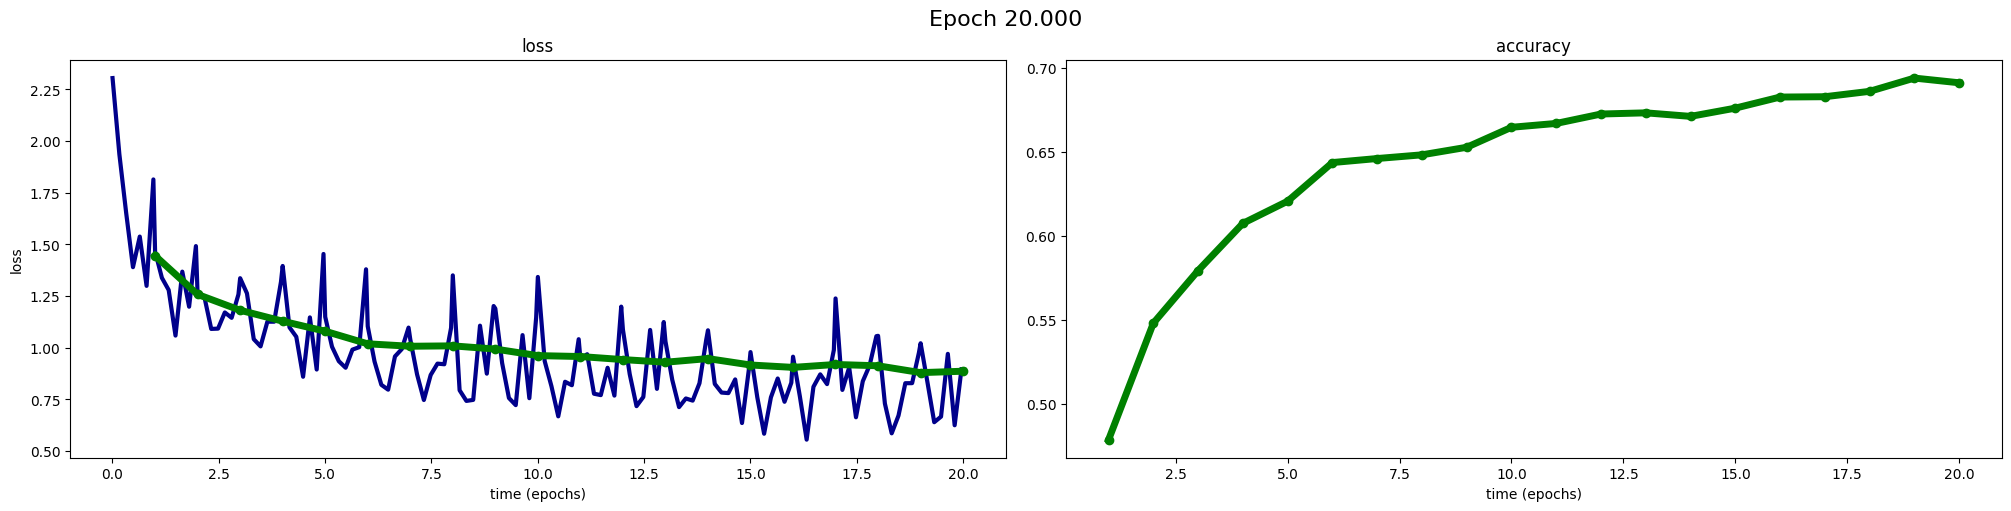

100%|██████████| 20/20 [21:20<00:00, 64.03s/it]


In [ ]:
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 20
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())

In [ ]:
best_acc

0.6941

#### 2.2

Теперь добавим батч-нормализацию

In [ ]:
model = CNN(batch_norm=True)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

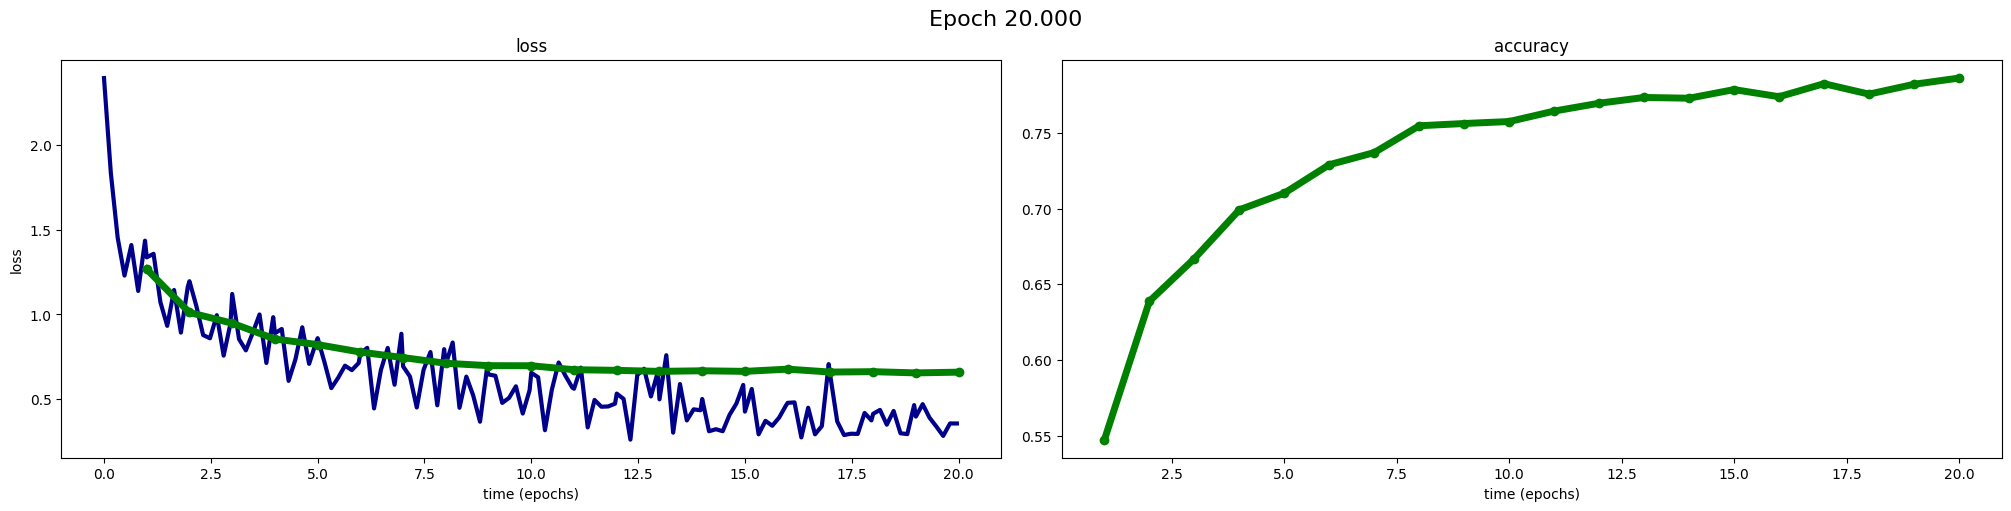

100%|██████████| 20/20 [22:30<00:00, 67.50s/it]


In [ ]:
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 20
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())

In [ ]:
best_acc

0.7862

С батч-нормализацией явно лучше

#### 2.3

Сделаем модель пожирнее: увеличим количество скрытых каналов

In [ ]:
model = CNN(out_1=64, out_2=128, out_3=256, fc1_out=512, fc2_out=256, batch_norm=True)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

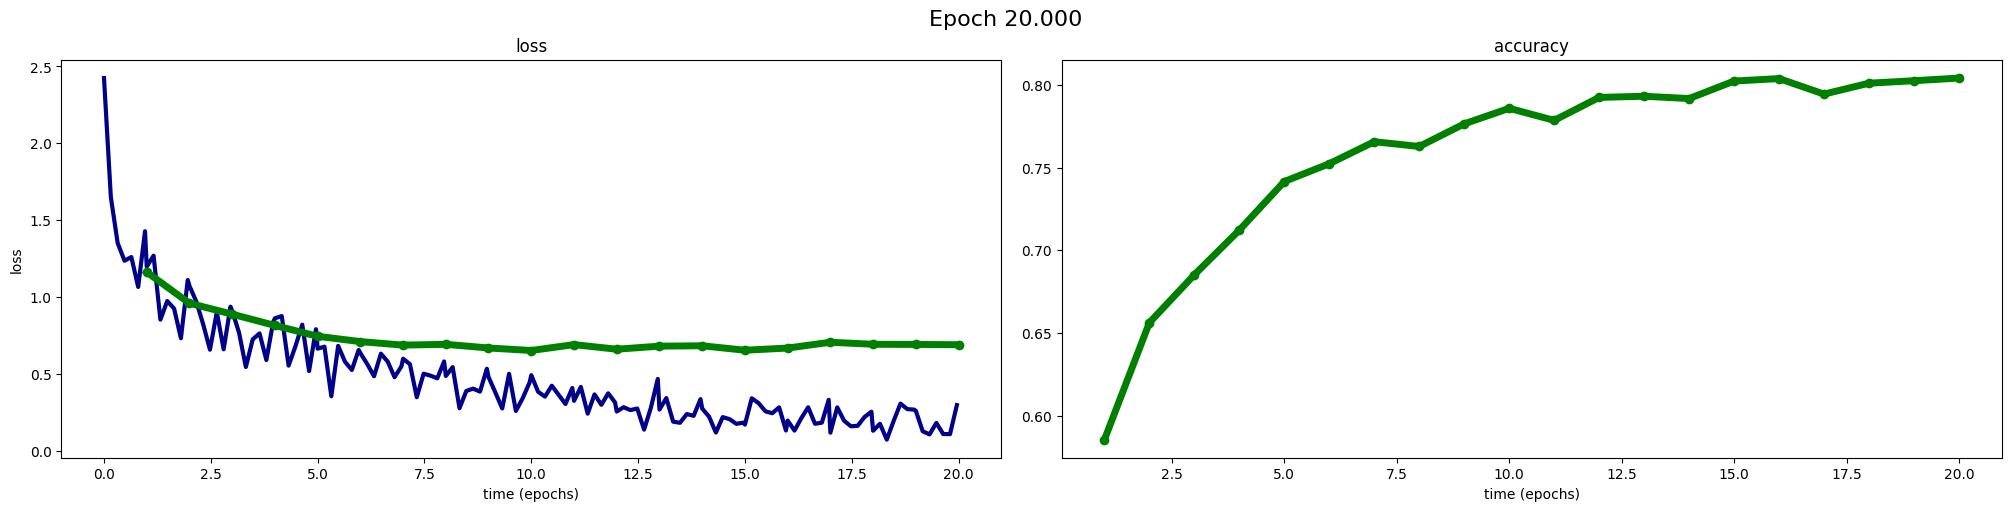

100%|██████████| 20/20 [36:07<00:00, 108.39s/it]


In [ ]:
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 20
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())

In [ ]:
best_acc

0.8042

Стало чуть лучше!

### Эксперимент 3

Теперь поиграем с предобученными моделями. Я решила взять EfficientNet small. Будем обучать по 10 эпох, иначе будет долго считаться + модель достаточно быстро оптимизируется.

#### 3.1

Посмотрим, как модель справляется с картинками без ресайза (нужно было сделать ресайз хотя бы до 33), то есть размером 33 * 33

In [ ]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

Нужно сделать новый хвост модели:

In [ ]:
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
      nn.Linear(in_features, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 10))
model = model.to(device)

Снова посмотрим на оптимизатор SGD

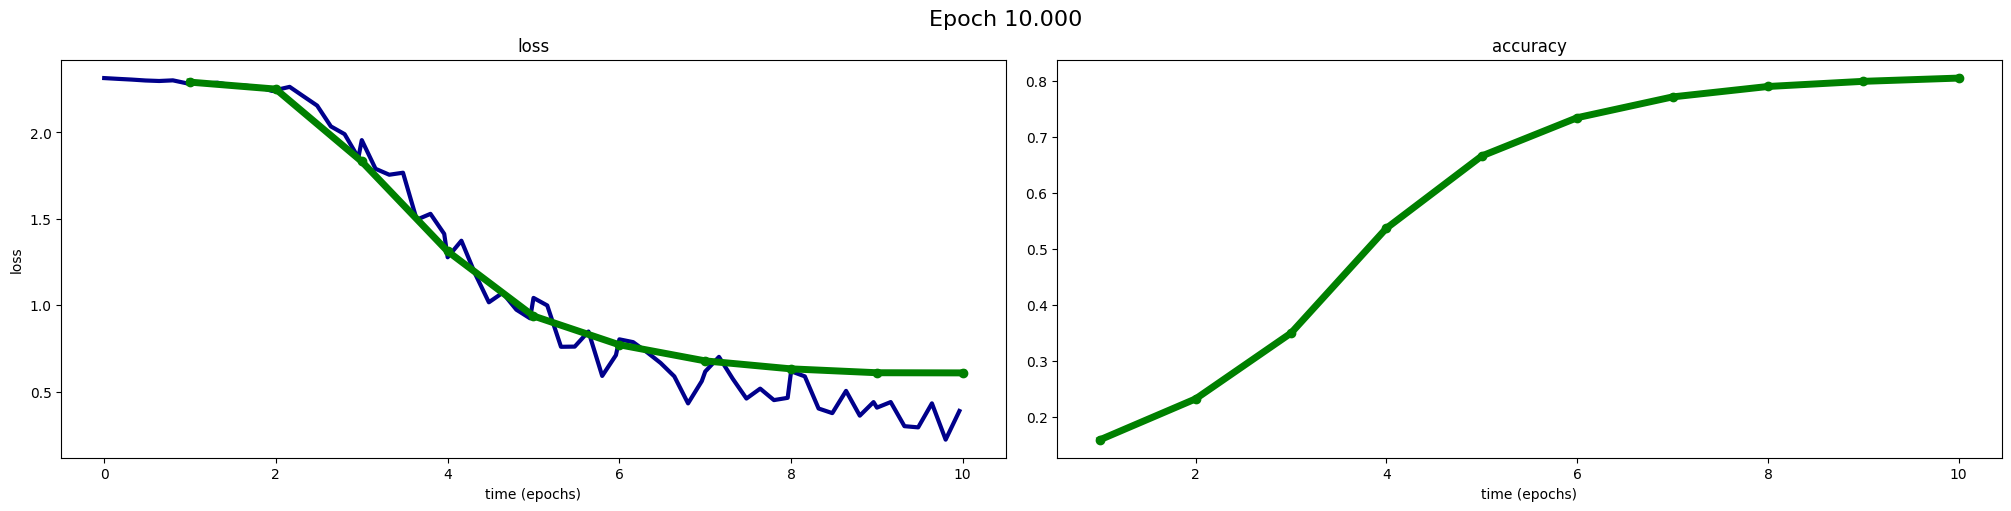

100%|██████████| 10/10 [15:04<00:00, 90.50s/it]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

epochs = 10
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())

#### 3.2

Теперь сделаем resize 224 * 224 (рекомендуемый размер в торче)

In [ ]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
      nn.Linear(in_features, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 10))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:02<00:00, 37.4MB/s]


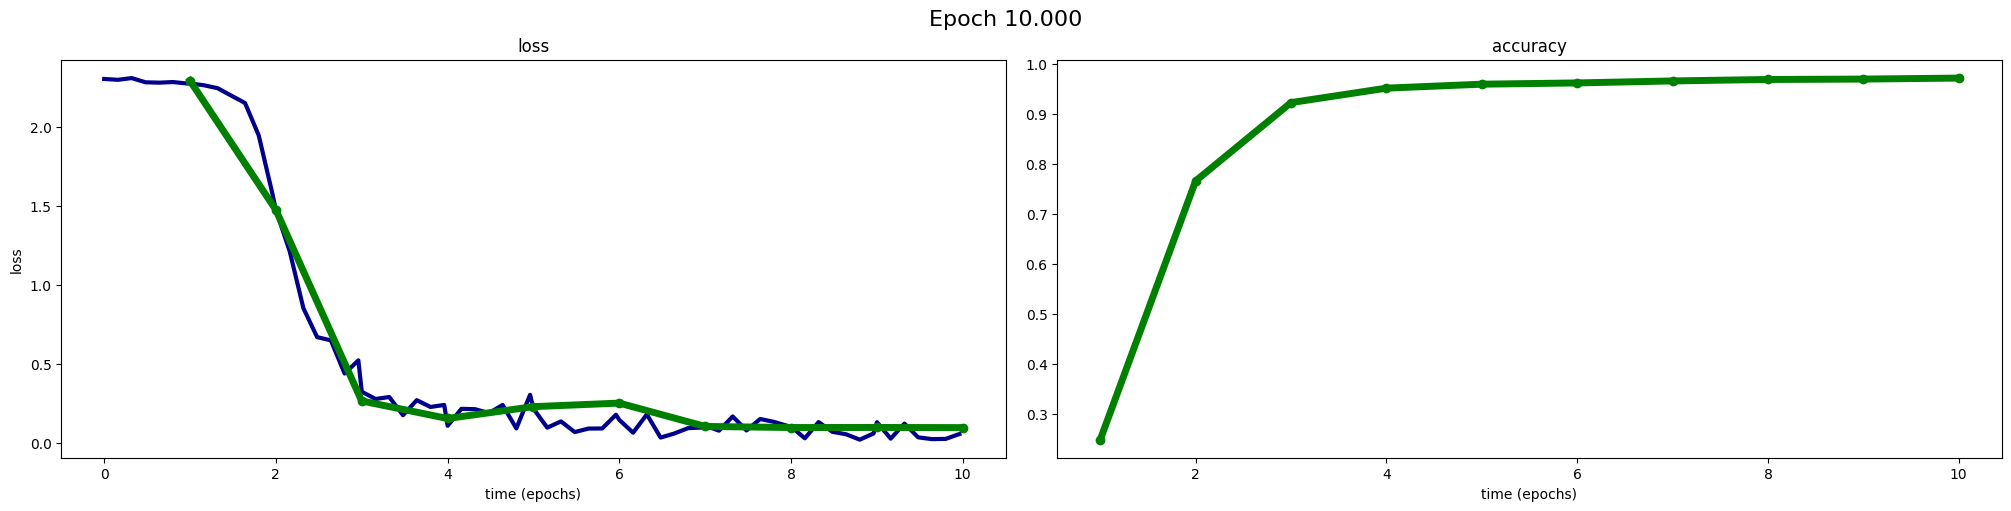

100%|██████████| 10/10 [1:18:51<00:00, 473.17s/it]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 10
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())


In [ ]:
print(best_acc)

0.9719


####3.3

Resize 128 * 128 и Adam и scheduler

In [ ]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
      nn.Linear(in_features, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 10))

model = model.to(device)

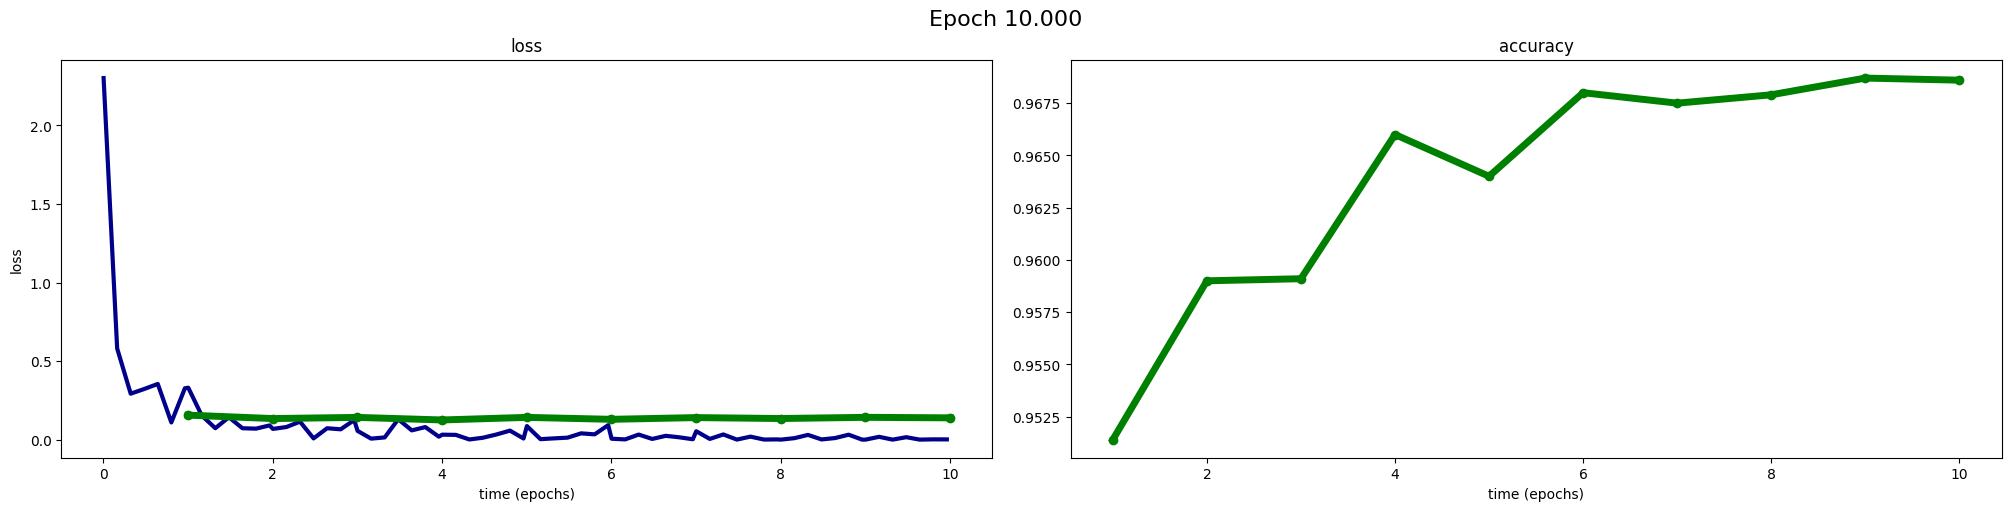

100%|██████████| 10/10 [29:43<00:00, 178.38s/it]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

# Training logs
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 10
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    scheduler.step()
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())

In [ ]:
best_acc

0.9687

#### 3.4

Resize 224 * 224, Adam, scheduler

In [ ]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
      nn.Linear(in_features, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 10))

model = model.to(device)

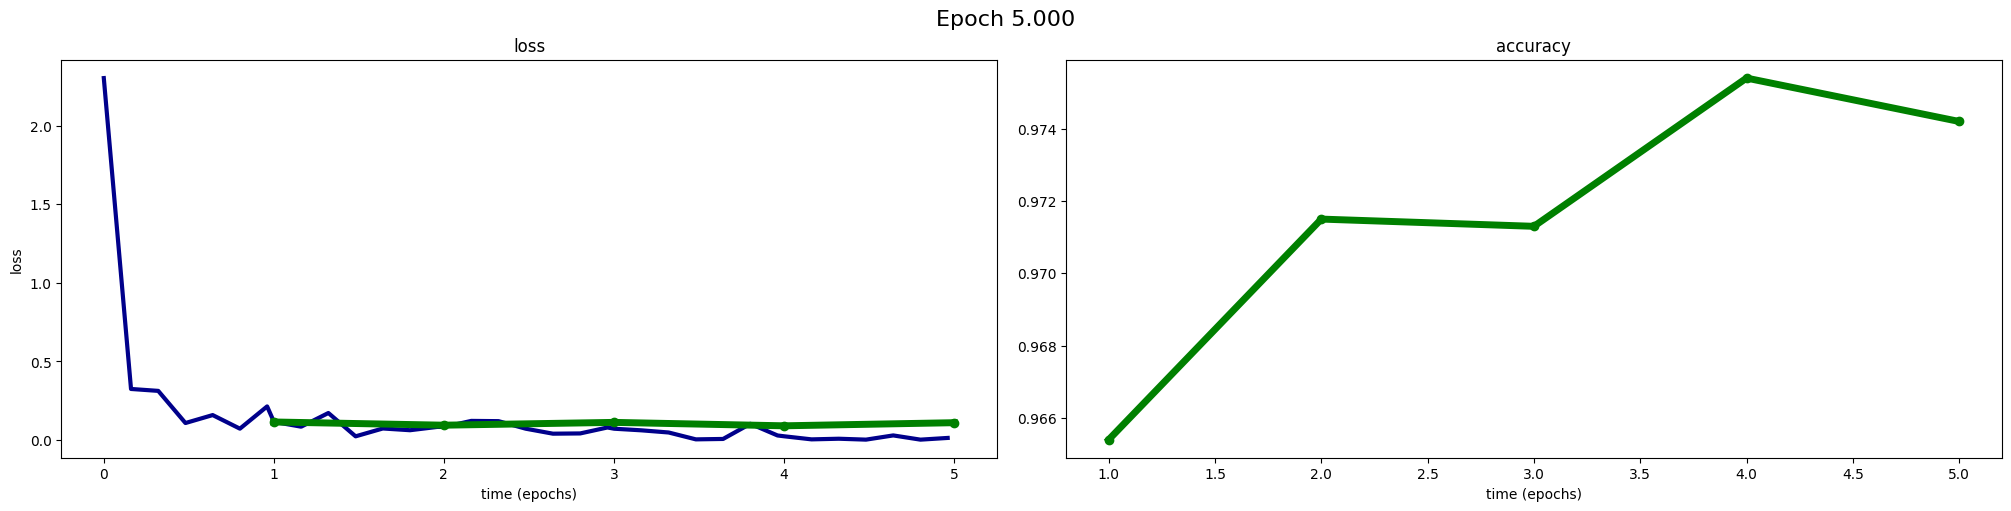

100%|██████████| 5/5 [41:11<00:00, 494.25s/it]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 5
best_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    scheduler.step()
    model, acc = test(t, val_dataloader, model, loss_fn)

    if acc > best_acc:
      best_acc = acc
      best_model_weights = copy.deepcopy(model.state_dict())

In [ ]:
best_acc

0.9754

На картинках размера 224 * 224 всего за 5 эпох получили самую высокую точность относительно остальных моделей и параметров. Именно эта модель на кагле зашла как лучшее решение (в соревановании я **tvoya_zvezdochka**)

### Отправка решения

Загружаем часть датасета для теста.

In [ ]:
test_data = CIFAR10(
    root=dataset_root,
    train=False,
    transform=test_transform)

In [ ]:
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

Делаем предсказания итоговой моделью.

In [ ]:
predictions = []

model.eval()
with torch.no_grad():
    for X, _ in test_dataloader:
        X = X.to(device)
        pred = model(X).argmax(1).cpu().numpy()
        predictions.extend(list(pred))

Формируем файл решения для отправки в kaggle.

In [ ]:
def write_solution(filename, labels):
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)

write_solution('solution.csv', predictions)